# Testing MPO

In [350]:
%reload_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings('ignore') 
import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Make oracles.

In [412]:
import os

dockstring_dir = f'{path}/dockstring_targets/'
files = os.listdir(dockstring_dir)
configs = sorted([f for f in files if 'conf' in f])
targets = sorted([f for f in files if 'target' in f])

idx = 9
with open(dockstring_dir + configs[idx], 'r') as f:
    config_ = f.readlines()
    config_ = [c.replace('\n', '') for c in config_]
    config_ = [c.split(' = ') for c in config_ if c]
    config_ = {c[0]: float(c[1]) for c in config_}

target = targets[idx]
name = target.split('_')[0]

config_.update({
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
})

from dgym.envs.oracle import DockingOracle, CatBoostOracle, RDKitOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'search_mode': 'detailed',
    'scoring': 'vina',
    'seed': 5,
    **config_
}

docking_oracle = DockingOracle(
    f'{name} affinity',
    receptor_path=f'{path}/dockstring_targets/{name}_target.pdbqt',
    config=config
)
log_P_oracle = RDKitOracle('MolLogP')
log_S_oracle = CatBoostOracle('Log S', path='../../dgym-data/models/aqsolcb.model')

# create evaluators
docking_cost_function = ClassicUtilityFunction(
    docking_oracle,
    ideal=(8, 9.5),
    acceptable=(7.7, 9.5)
)

log_P_cost_function = ClassicUtilityFunction(
    log_P_oracle,
    ideal=(0.5, 1.85),
    acceptable=(-0.5, 3.5)
)

log_S_cost_function = ClassicUtilityFunction(
    log_S_oracle,
    ideal=(-1, 1),
    acceptable=(-4, 1)
)

assays = [
    docking_oracle,
    log_P_oracle,
    log_S_oracle
]

cost_functions = [
    docking_cost_function,
    log_P_cost_function,
    log_S_cost_function
]

Instantiate designer.

In [414]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [415]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
initial_library = dg.MoleculeCollection(initial_molecules)
initial_library.update_annotations()
library = initial_library

Prepare MPO ranking function.

In [416]:
import numpy as np
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

def rank_molecules(costs):
    
    costs = np.nan_to_num(costs)

    # Multi-dimensional non-dominated fusion sort
    nds, nds_ranks = NonDominatedSorting().do(
        costs, return_rank=True, only_non_dominated_front=False)
    penalty_sums = np.sum(costs, axis=1)
    fused_ranks = np.lexsort([penalty_sums, nds_ranks]) # prioritizes last column
    
    return fused_ranks.tolist()

Multi-step selection.

In [385]:
import numpy as np
from tqdm.notebook import tqdm

for molecule in library:
    molecule.update_annotations(
        {'timestep': 0, **{a.name: a(molecule) for a in assays}})

costs = np.asarray([cost(library) for cost in cost_functions[:2]]).T
ranking = rank_molecules(costs)
best = ranking

print([cost(library[best]) for cost in cost_functions])
print(best)

for step in tqdm(range(1, 10)):
    
    analogs = []
    for b in best:
        if step % 5 == 2:
            analogs += designer.design(
                library[b], 8, strategy='grow')
        else:
            analogs += designer.design(
                library[b], 8, strategy='replace', temperature=0.0)

    # Get costs
    library += analogs
    costs = np.asarray([cost(library) for cost in cost_functions]).T

    ranking = rank_molecules(costs)
    best = ranking[:5]
    # best = np.random.choice(len(costs))

    for analog in analogs:
        analog.update_annotations(
            {'timestep': step, **{a.name: a(analog) for a in assays}})

    print(step, costs[best])
    print(step, best)

[array([ 5.89179732,  5.82084838,  9.64673071, 12.82482519, 22.08803782]), array([0.    , 0.208 , 0.    , 0.    , 0.5754]), array([0.21011975, 0.70240432, 0.55158691, 0.16956672, 0.        ])]
[1, 0, 4, 3, 2]


  0%|          | 0/9 [00:00<?, ?it/s]

1 [[ 3.71327527  0.          0.38193514]
 [ 3.70029563  0.          0.42974413]
 [ 2.86596165  0.90430303  0.69507912]
 [ 5.89179732  0.          0.21011975]
 [12.82482519  0.          0.16956672]]
1 [6, 8, 7, 1, 3]
2 [[1.96906416 0.13557576 0.83377921]
 [2.59089311 0.         0.61143724]
 [3.11017008 0.         0.4808277 ]
 [3.71327527 0.         0.38193514]
 [3.70029563 0.         0.42974413]]
2 [56, 59, 57, 6, 8]
3 [[1.42070581 0.06945455 0.82028276]
 [2.52682826 0.         0.41496547]
 [1.5898371  0.56854545 0.81429155]
 [2.49974443 0.         0.85426706]
 [2.6673     0.5735     0.34646063]]
3 [79, 95, 99, 82, 100]
4 [[1.42070581 0.06945455 0.82028276]
 [1.60070928 0.         0.8284248 ]
 [2.13309161 0.         0.52918415]
 [2.05325542 0.         0.64581329]
 [2.05171085 0.         0.72507875]]
4 [79, 120, 150, 127, 147]
5 [[1.42070581 0.06945455 0.82028276]
 [1.54795132 0.         0.76937365]
 [2.13309161 0.         0.52918415]
 [2.05325542 0.         0.64581329]
 [2.01087089 0.  

# Visualizing results

Text(0.5, 1.0, 'Heavy atom count vs. pIC50')

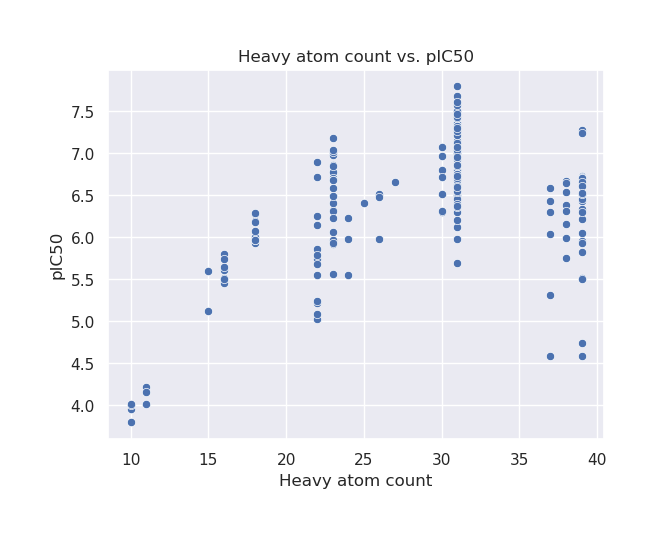

In [386]:
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem.Descriptors import HeavyAtomCount

sns.set()
sns.scatterplot(
    x=[HeavyAtomCount(m.mol) for m in library],
    y=docking_oracle(library),
)

plt.xlabel('Heavy atom count')
plt.ylabel('pIC50')
plt.title('Heavy atom count vs. pIC50')

<Figure size 1920x1440 with 0 Axes>

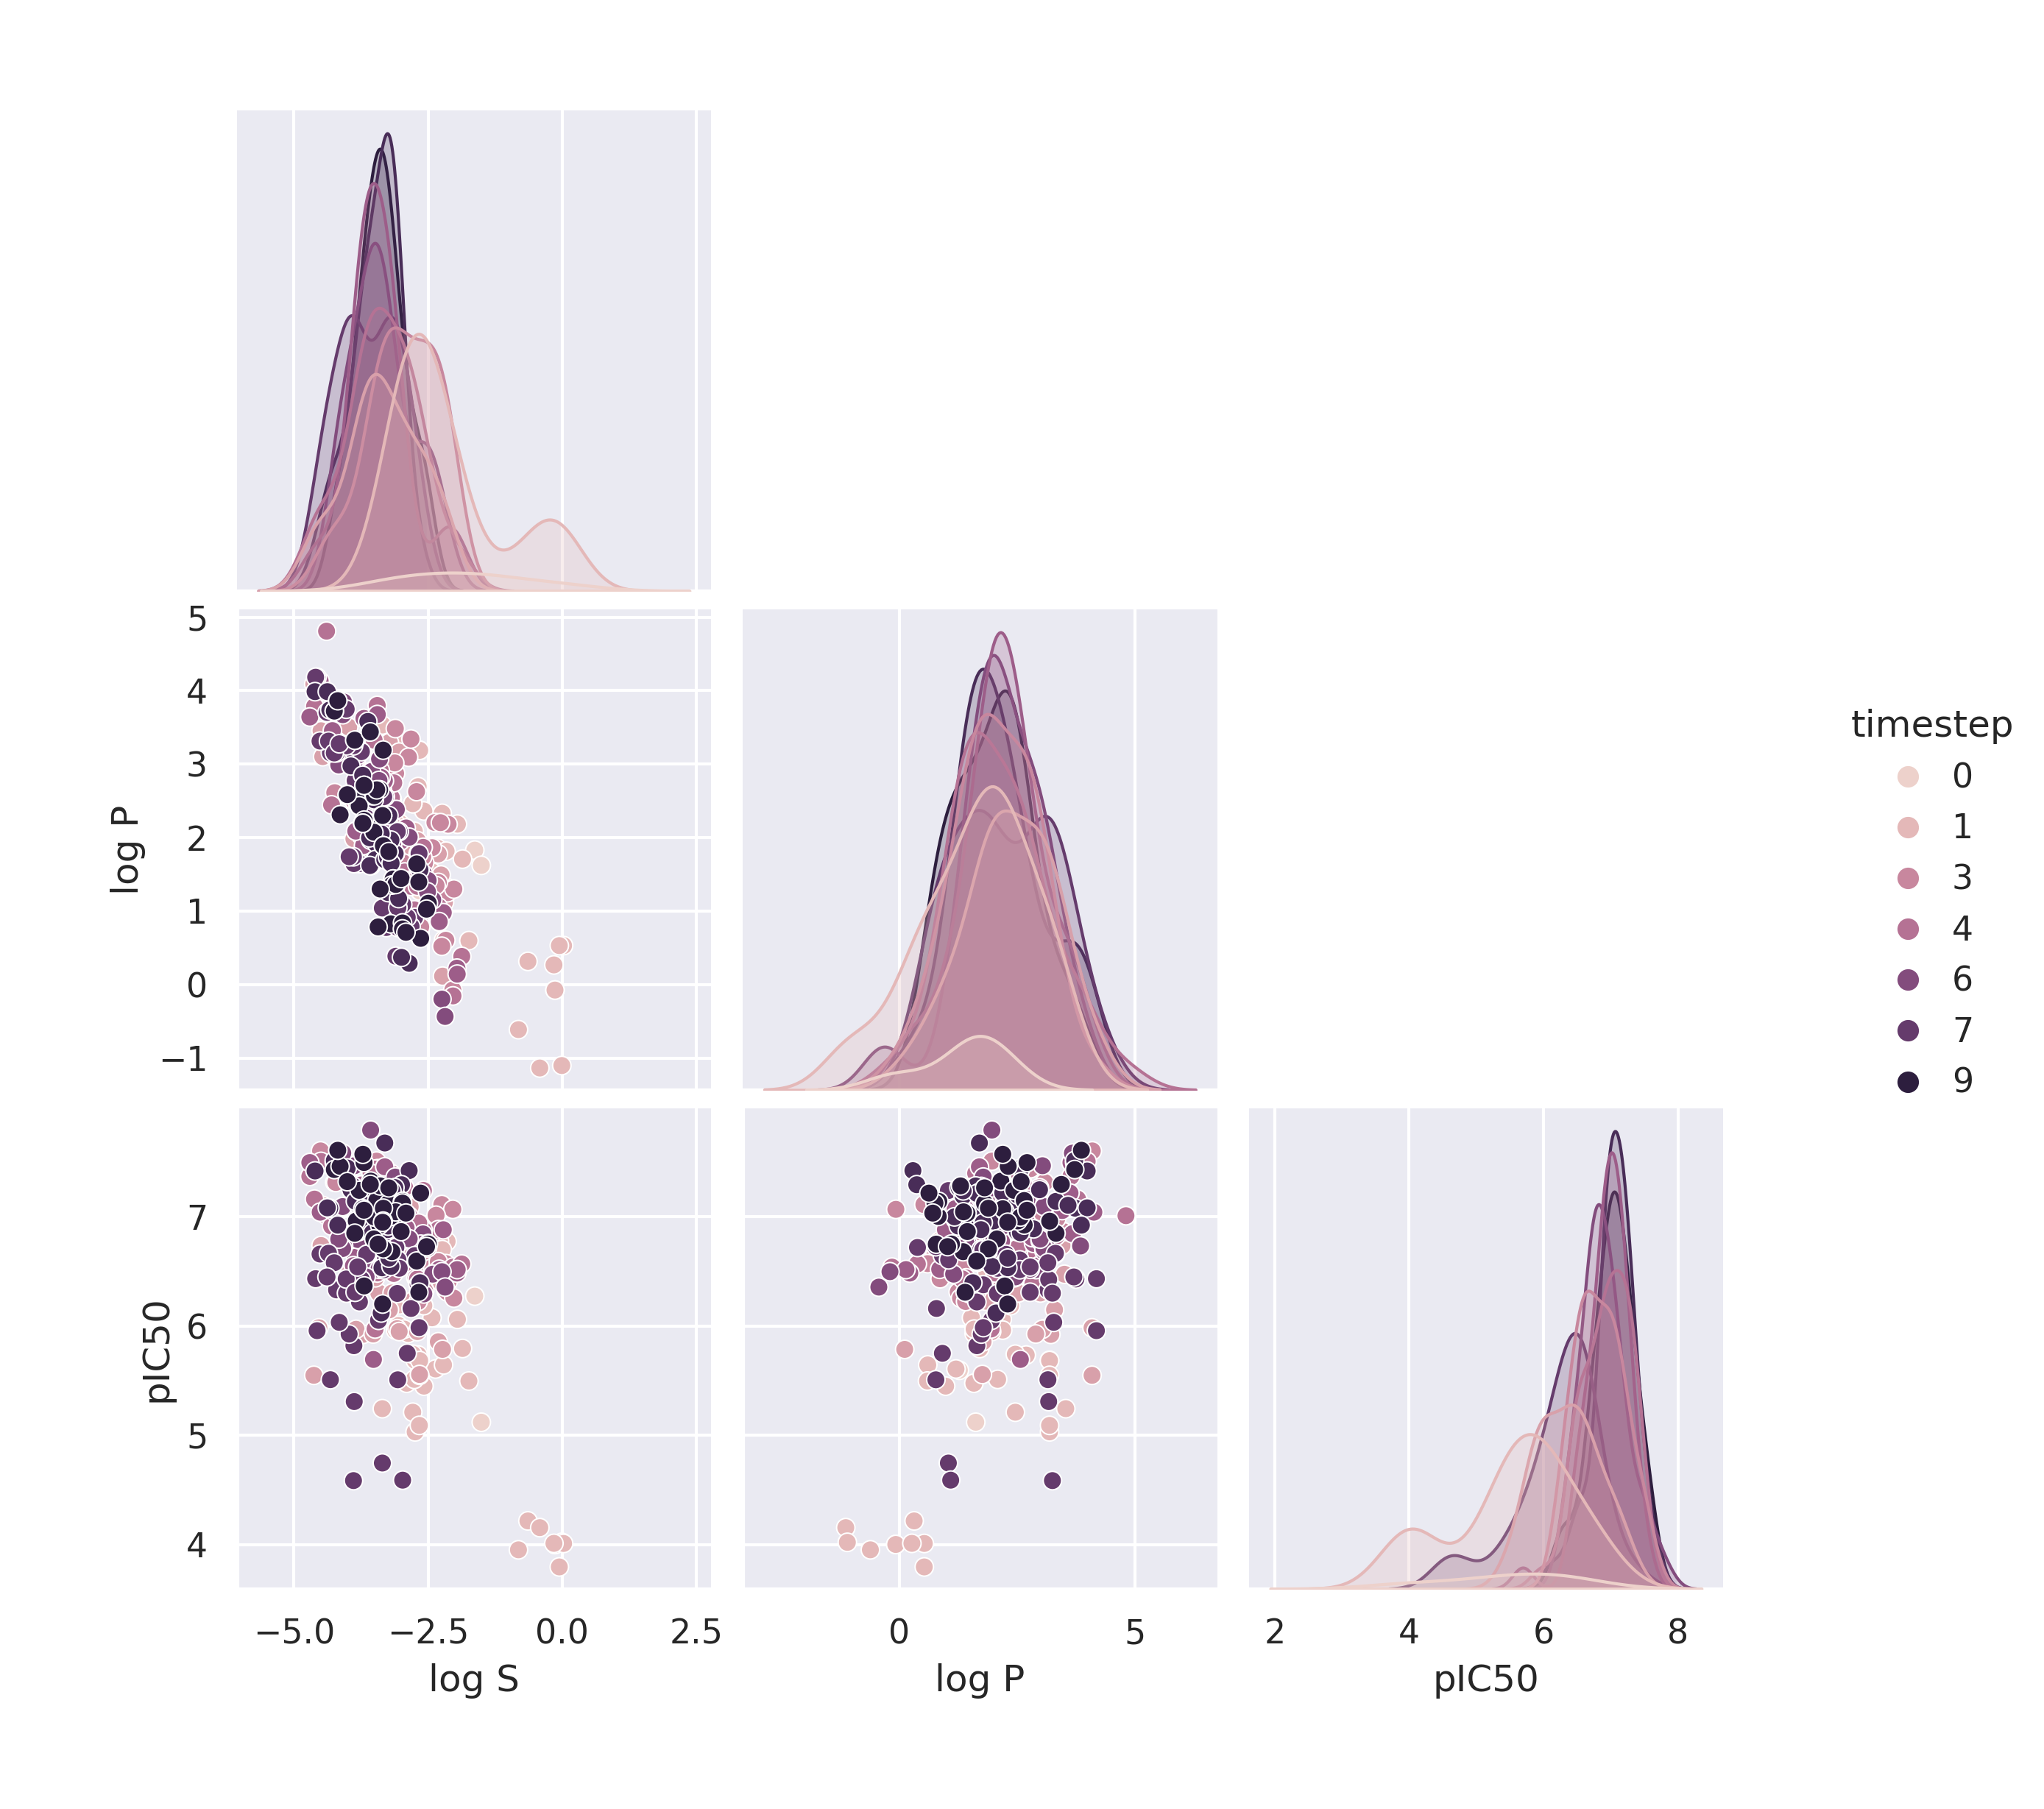

In [387]:
import pandas as pd

plt.figure(dpi=300)

sns.set_theme()
g = sns.pairplot(
    pd.DataFrame([{
        'log S': log_S_oracle(l)[0],
        'log P': log_P_oracle(l)[0],
        'pIC50': docking_oracle(l)[0],
        'timestep': l.annotations['timestep']
    } for l in library]),
    corner=True,
    hue='timestep'
)
g.fig.set_dpi(300)

## Visualizing the best across rounds

A trajectory of the best molecule each round.

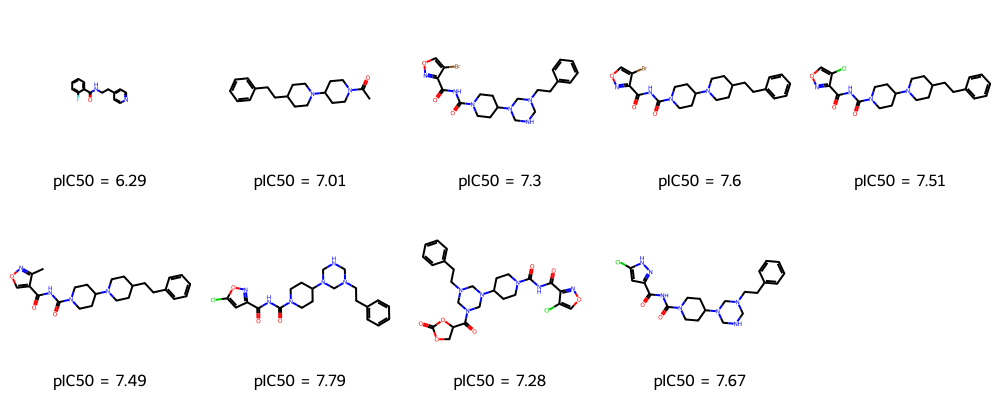

In [409]:
best_across_round = [
    library.annotations.query(f'timestep == {i}')[f'{name} affinity']
    .sort_values(na_position='first')
    .index[-1].item()
    for i in range(int(library.annotations.timestep.max()))
    if library.annotations.query(f'timestep == {i}')[f'{name} affinity'].any()
]

from rdkit.Chem.Draw import MolsToGridImage

get_affinity = lambda idx: library[idx][f'{name} affinity'][0]
MolsToGridImage(
    [m.mol for m in library[best_across_round]],
    molsPerRow=5,
    legends=[f'pIC50 = {round(get_affinity(b), 2)}' for b in best_across_round]
)

A trajectory of the best molecule.

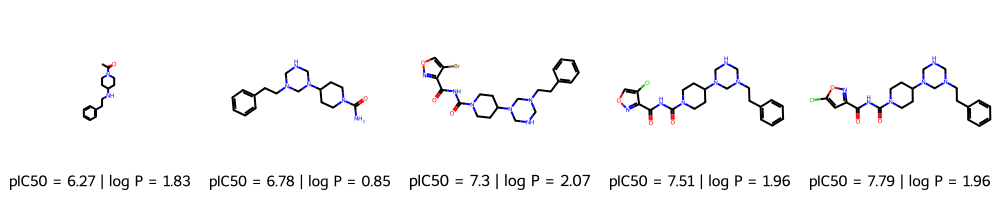

In [390]:
mol = library[np.nanargmax(docking_oracle(library)).item()]
milestones = [mol]
while mol.inspiration:
    milestones.append(mol.inspiration)
    mol = mol.inspiration
    
milestones = list(reversed(milestones))

MolsToGridImage(
    [m.mol for m in milestones],
    molsPerRow=5,
    legends=[f'pIC50 = {round(docking_oracle(m)[0], 2)} | log P = {round(log_P_oracle(m)[0], 2)}' for m in milestones]
)

Text(0.5, 1.0, 'New compounds synthesized each round')

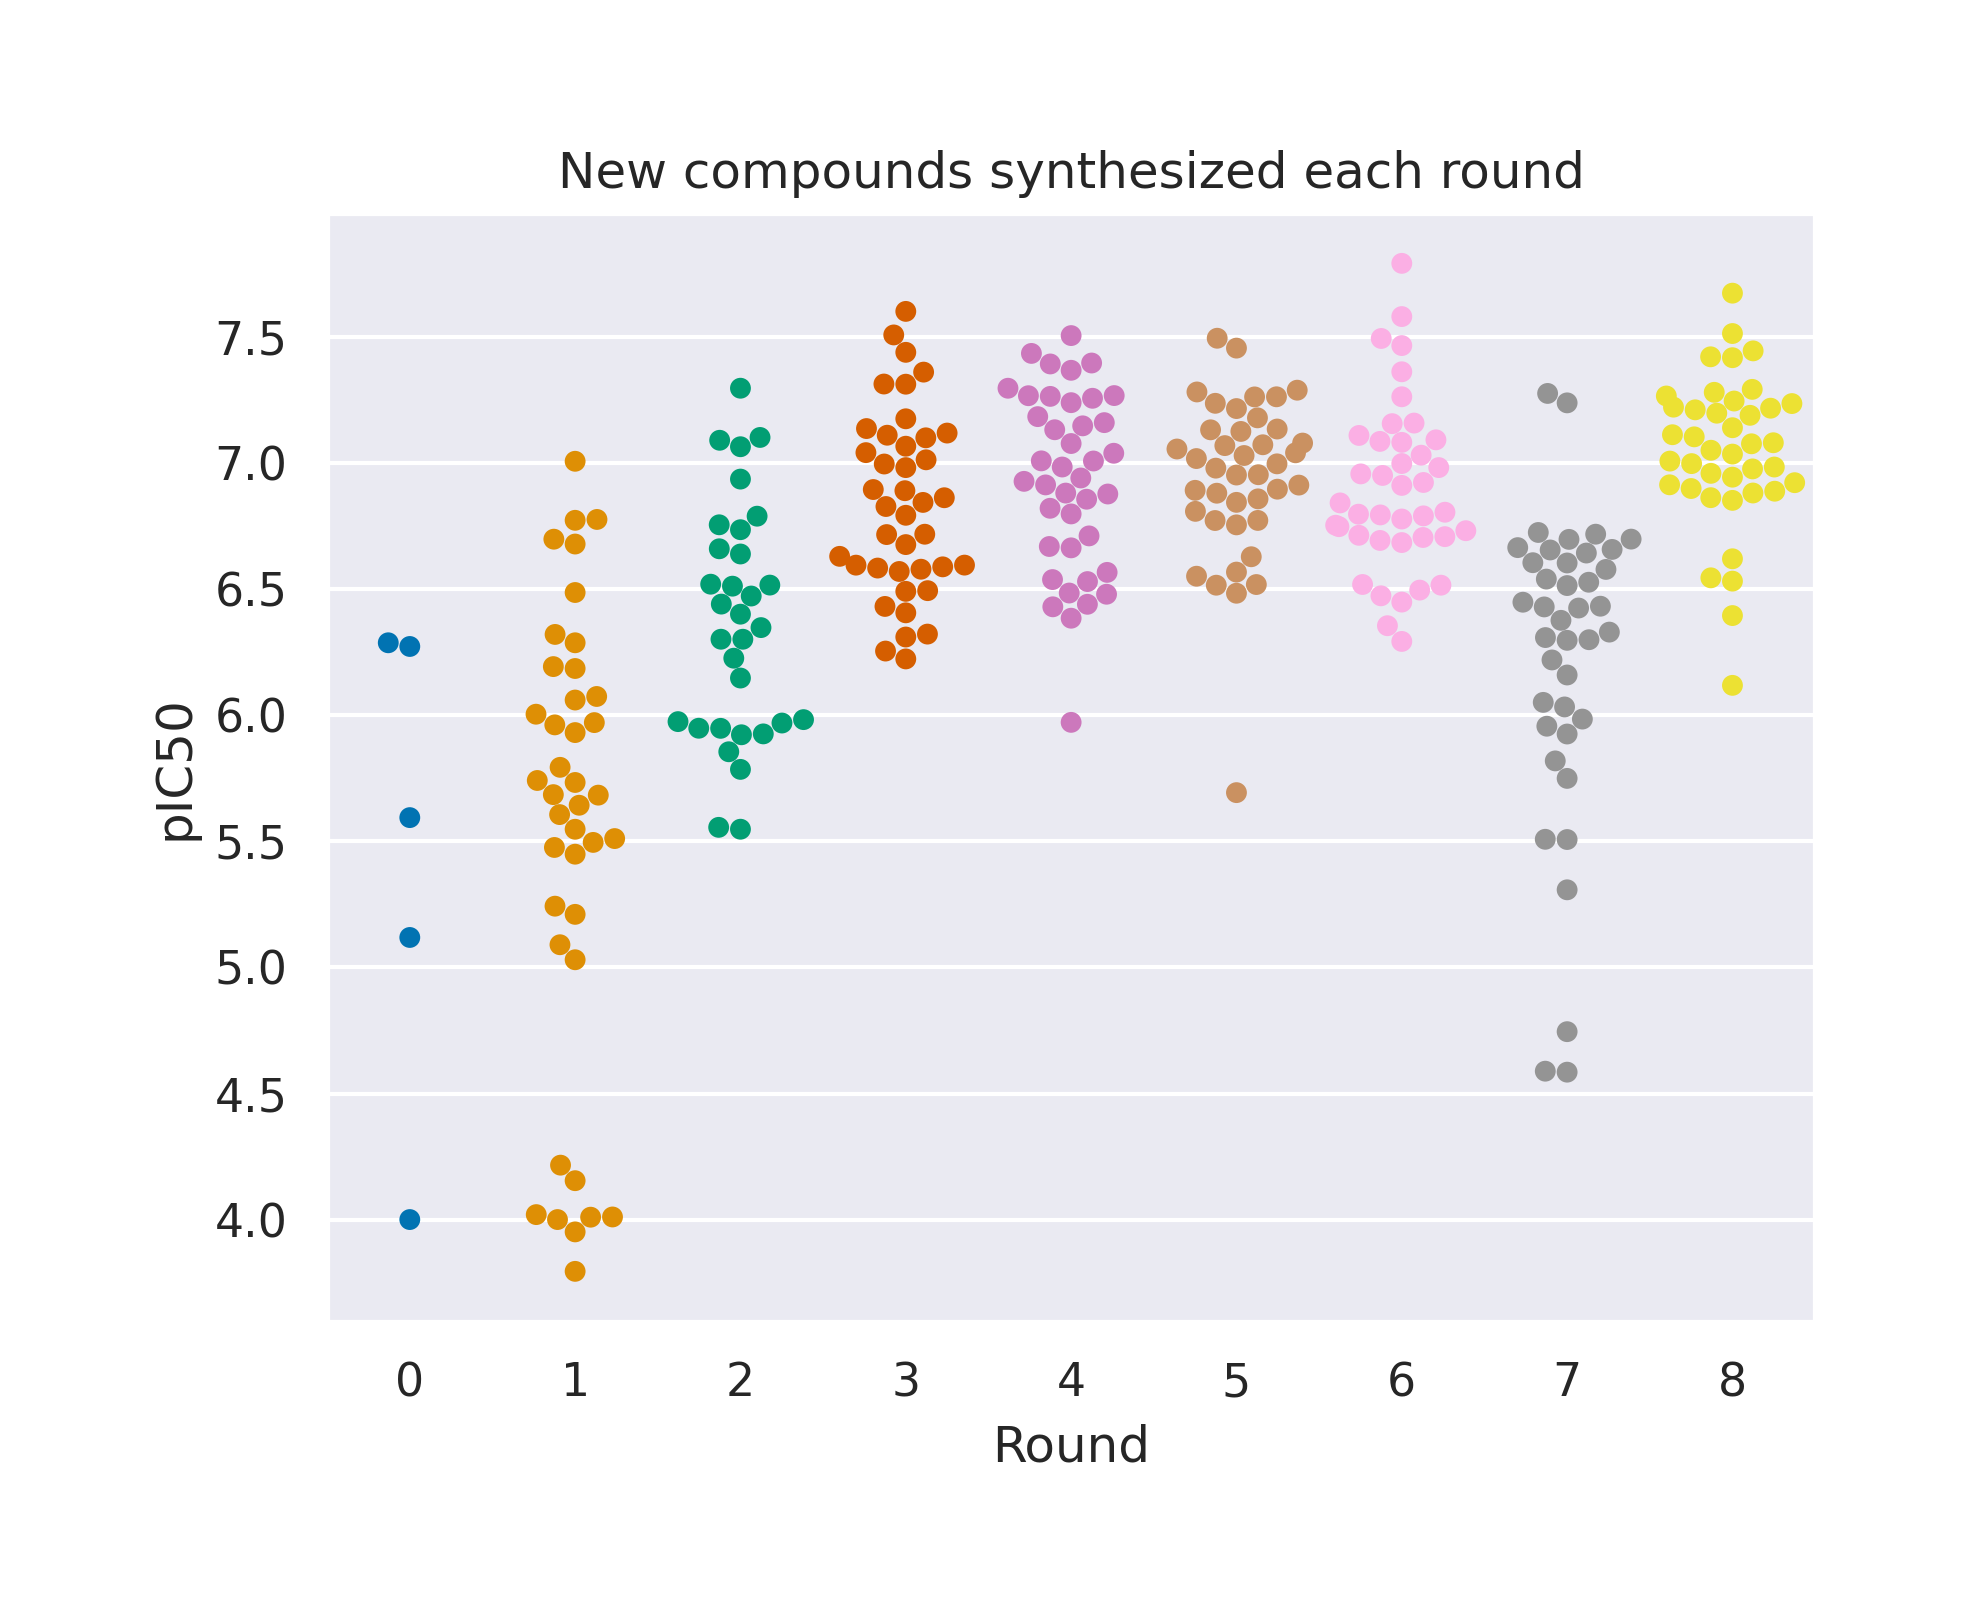

In [392]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(dpi=300)
sns.set()

objective = f'{name} affinity'
annotations = library.annotations.iloc[:-40]
annotations[objective] = [l[0] for l in annotations[objective]]

sns.swarmplot(
    annotations,
    x='timestep',
    y=objective,
    hue='timestep',
    palette='colorblind',
    # complementary=True,
    legend=False
)

plt.ylabel('pIC50')
plt.xlabel('Round')
plt.title('New compounds synthesized each round')

In [394]:
max_timestep = int(library.annotations.timestep.max())

records = []
for timestep, group in library.annotations.groupby('timestep'):
    for _, mol in group.iterrows():
        record = {'pIC50': mol[f'{name} affinity'][0], 'timestep': timestep}
        records.append(record)
        
        # Duplicate logic for each possible timestep
        for t in range(1, max_timestep + 1):
            if timestep < t:
                records.append({**record, 'timestep': t})

df = pd.DataFrame(records)

Text(0.5, 1.0, 'Distribution of ligand potencies across rounds')

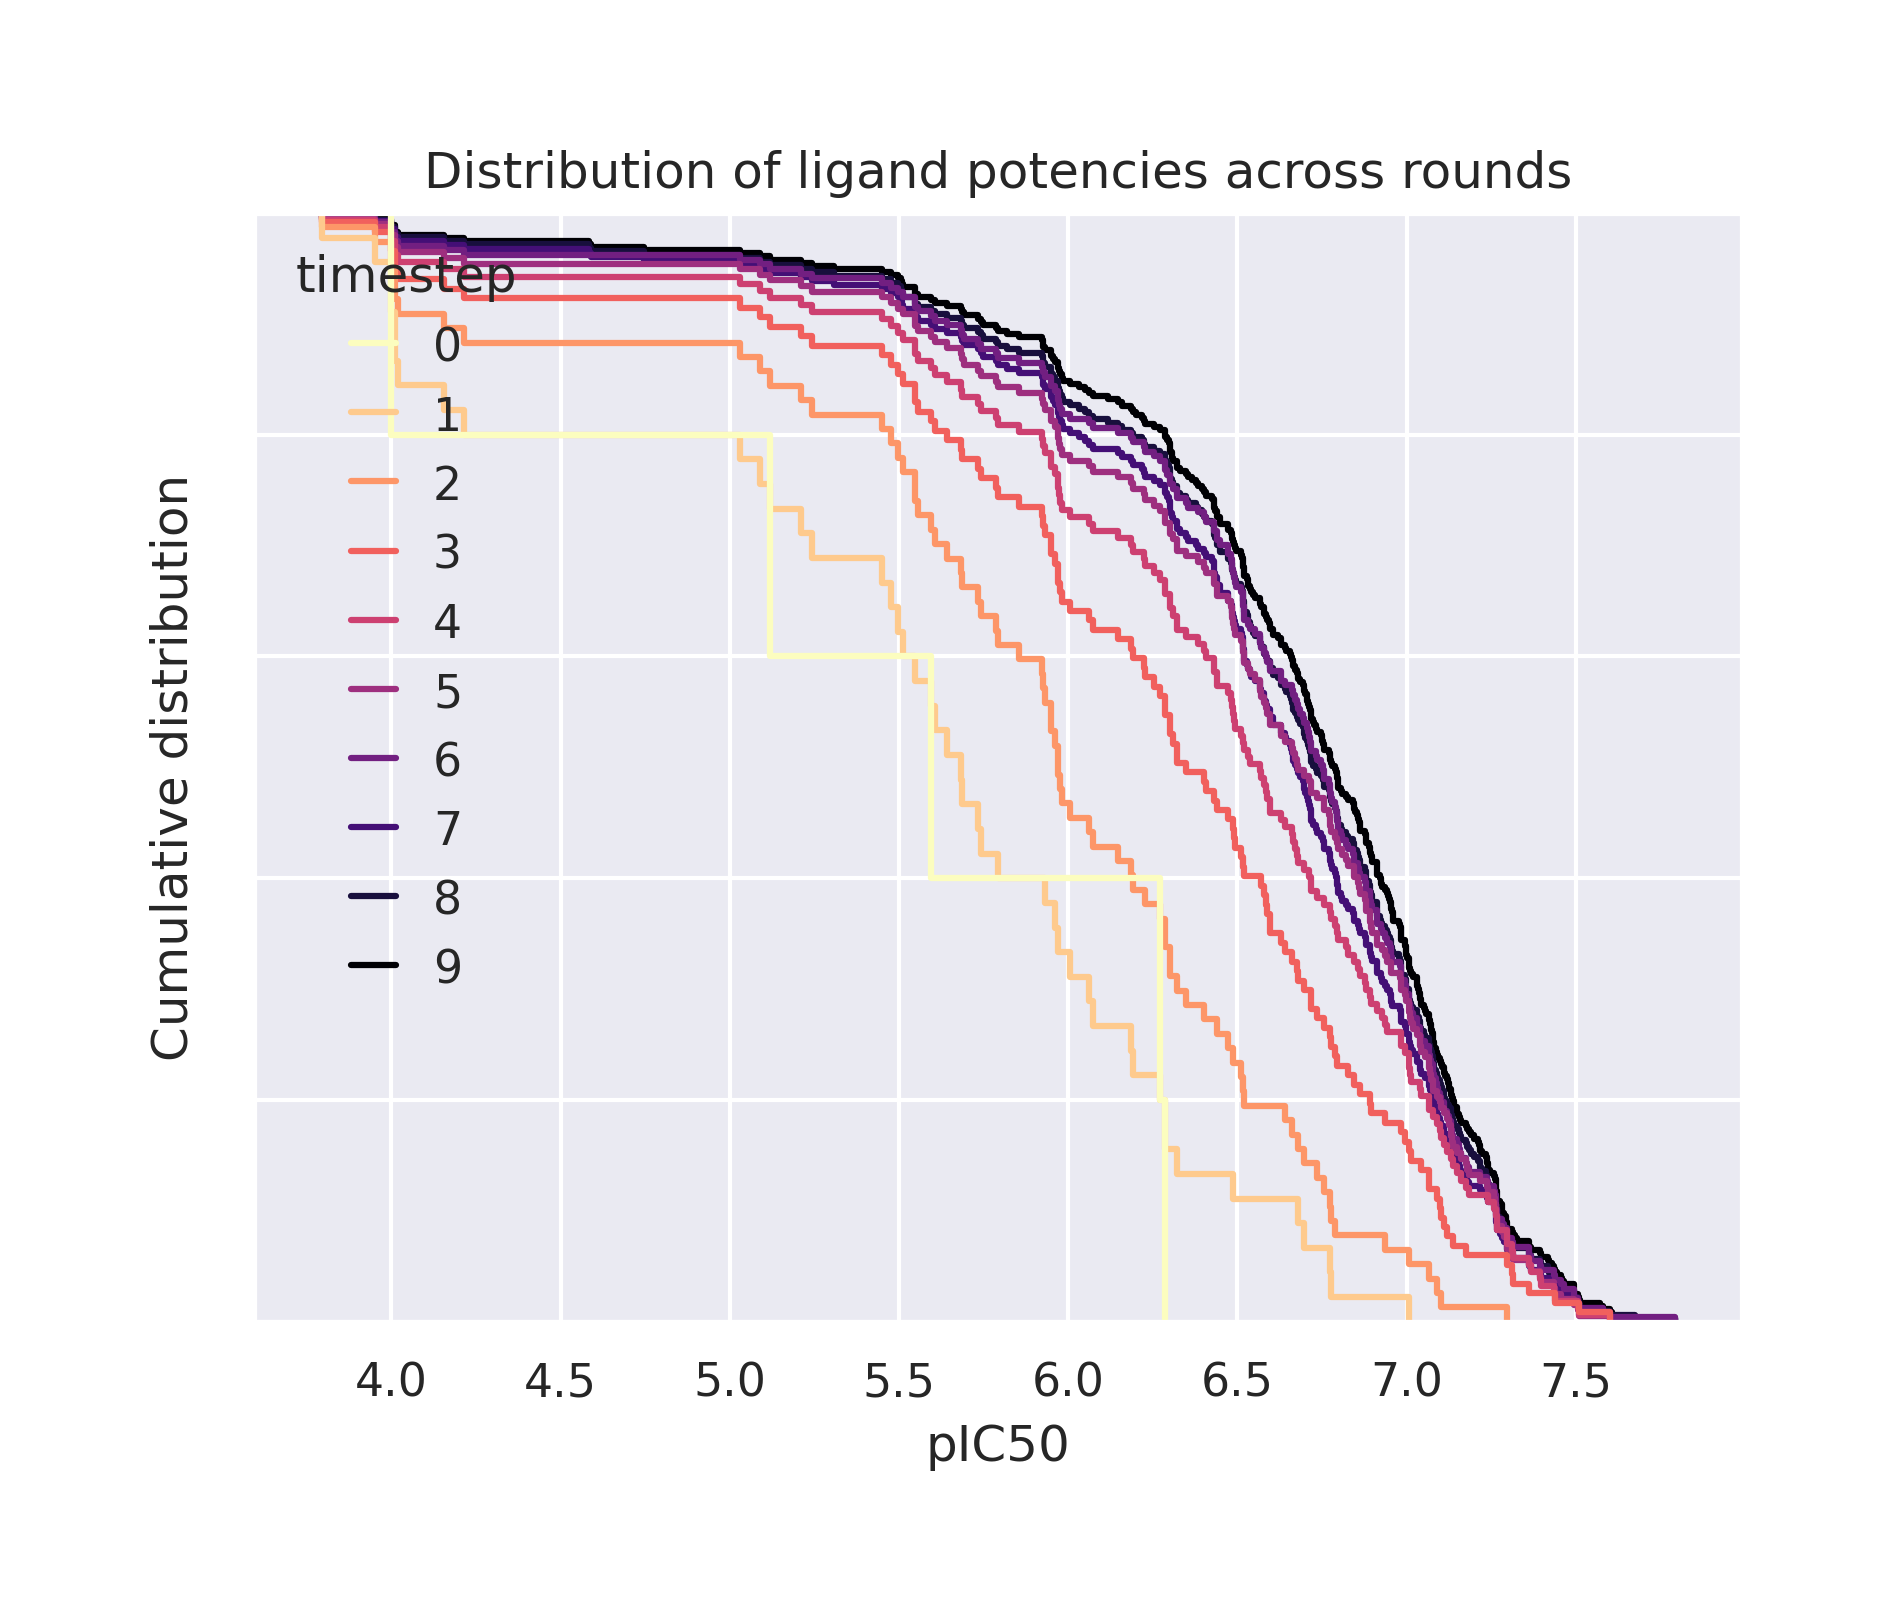

In [408]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(dpi=300)

g = sns.ecdfplot(
    df,
    x='pIC50',
    hue='timestep',
    palette='magma_r',
    complementary=True
)

g.set(yticklabels=[])

plt.xlabel('pIC50')
plt.ylabel('Cumulative distribution')
plt.title('Distribution of ligand potencies across rounds')

Text(0.5, 1.0, 'Assay values across time')

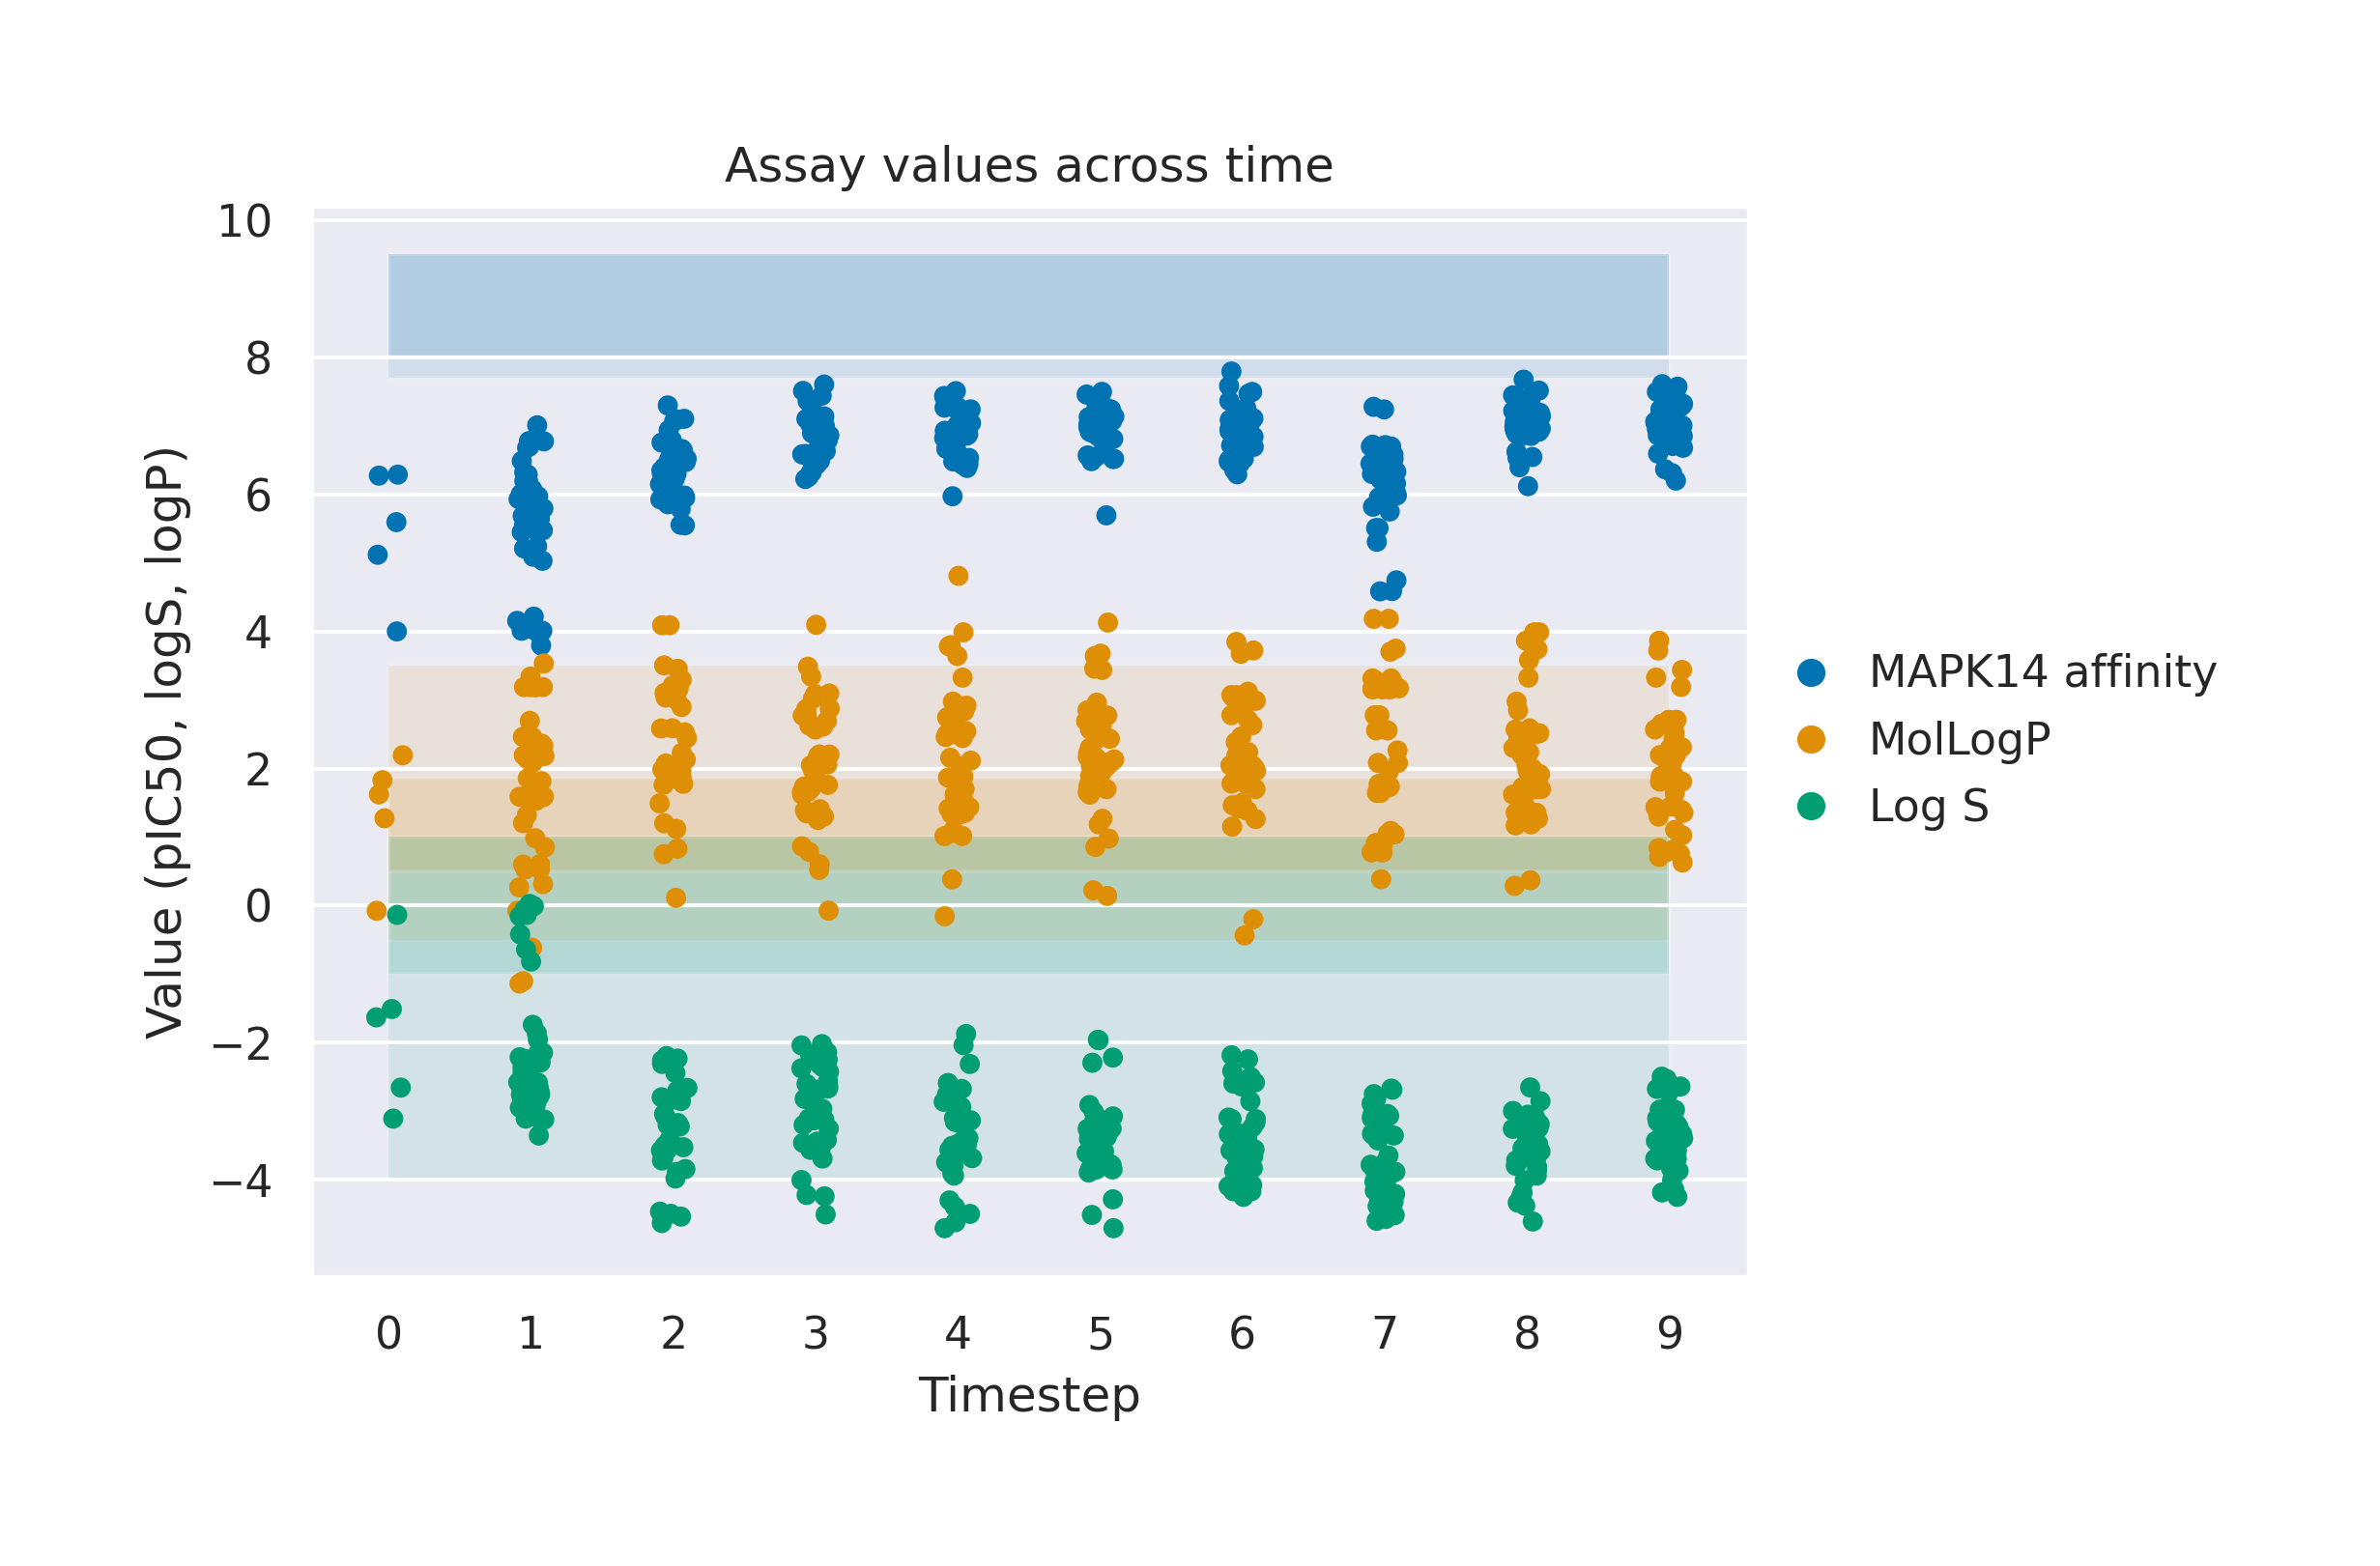

In [396]:
plt.figure(dpi=300)
sns.set_theme()

annotations = (
    library.annotations
    .map(lambda x: x[0] if isinstance(x, list) else x)
    [['timestep', f'{name} affinity', 'MolLogP', 'Log S']]
)

annotations = pd.melt(
    annotations,
    id_vars=['timestep'],
    var_name='assay',
    value_name='value'
)

g = sns.stripplot(
    annotations,
    x='timestep',
    y='value',
    hue='assay',
    palette='colorblind'
)

plt.fill_betweenx(
    log_S_cost_function.acceptable, 0, annotations.timestep.max(), alpha=0.1, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[2]
)
plt.fill_betweenx(
    log_P_cost_function.acceptable, 0, annotations.timestep.max(), alpha=0.1, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[1]
)
plt.fill_betweenx(
    docking_cost_function.acceptable, 0, annotations.timestep.max(), alpha=0.1, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[0]
)

plt.fill_betweenx(
    log_S_cost_function.ideal, 0, annotations.timestep.max(), alpha=0.15, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[2]
)
plt.fill_betweenx(
    log_P_cost_function.ideal, 0, annotations.timestep.max(), alpha=0.15, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[1]
)
plt.fill_betweenx(
    docking_cost_function.ideal, 0, annotations.timestep.max(), alpha=0.15, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[0]
)

g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Timestep')
plt.ylabel('Value (pIC50, logS, logP)')
plt.title('Assay values across time')

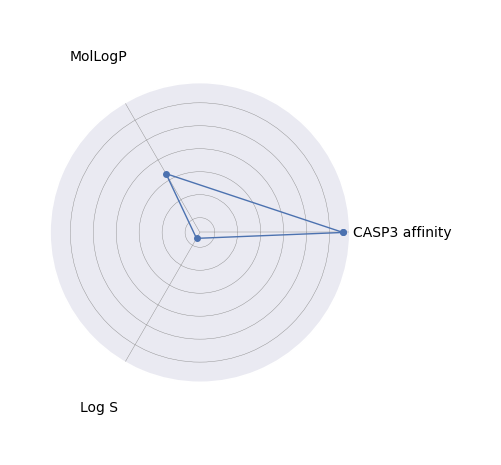

In [277]:
from radar import radar_chart
import matplotlib.pyplot as plt

annotations = (
    library.annotations.map(
    lambda x: x[0] if isinstance(x, list) else x)
    [['CASP3 affinity', 'MolLogP', 'Log S']]
)

labels = annotations.columns
values = annotations.iloc[0]

radar_chart(
    labels=labels, values=values, fill_alpha=0)
plt.show()

Docking on-disk.

In [397]:
[m.smiles for m in milestones]

['CC(=O)N1CCC(NCCc2ccccc2)CC1',
 'NC(=O)N1CCC(N2CNCN(CCc3ccccc3)C2)CC1',
 'O=C(NC(=O)N1CCC(N2CNCN(CCc3ccccc3)C2)CC1)c1nocc1Br',
 'O=C(NC(=O)N1CCC(N2CNCN(CCc3ccccc3)C2)CC1)c1nocc1Cl',
 'O=C(NC(=O)N1CCC(N2CNCN(CCc3ccccc3)C2)CC1)c1cc(Cl)on1']

In [349]:
import math
-10 * (-math.log10(math.e) / 0.6)

7.238241365054198

In [398]:
results = docking_oracle(
    milestones,
    path='../../dgym-data/out/docking_results',
    use_cache=False
)

In [405]:
docking_oracle(milestones)

[6.27269752113896,
 6.776384750526121,
 7.296766533384143,
 7.508066355767819,
 7.791938663428659]

In [400]:
len(milestones)

5

In [403]:
results

[6.81968580148771,
 7.3582344657828385,
 6.135825046250348,
 7.05259289775262,
 7.298648616579365,
 5.759433435332241,
 6.496045845927947,
 5.632702302331182]